In [1]:
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from shapely.geometry import Point, Polygon
from qgis.core import QgsProject, QgsVectorLayer
from qgis.core import (
    QgsProject, QgsVectorLayer, QgsGeometry, QgsFeature, QgsField, QgsPointXY
)
from qgis.PyQt.QtGui import QColor  # Import QColor for styling
from qgis.PyQt.QtCore import QVariant

In [2]:
# Step 1: Load the India shapefile and landslide data
def load_data(india_shapefile_path, landslide_data_path):
    india_gdf = gpd.read_file(india_shapefile_path)  # Load India shapefile
    landslide_df = pd.read_csv(landslide_data_path)  # Load landslide CSV data
    return india_gdf, landslide_df


In [3]:
# Step 2: Convert the landslide DataFrame to a GeoDataFrame with coordinates
def prepare_geodataframe(landslide_df):
    geometry = [Point(xy) for xy in zip(landslide_df['longitude'], landslide_df['latitude'])]
    landslide_gdf = gpd.GeoDataFrame(landslide_df, geometry=geometry)
    landslide_gdf.set_crs(epsg=4326, inplace=True)  # Set to WGS84 CRS
    return landslide_gdf

In [4]:
# Step 3: Apply K-means clustering to group the landslide points
def apply_kmeans(landslide_gdf, n_clusters=5):
    kmeans = KMeans(n_clusters=n_clusters)
    coordinates = landslide_gdf[['longitude', 'latitude']].values
    kmeans.fit(coordinates)
    
    # Assign cluster labels to the GeoDataFrame
    landslide_gdf['cluster'] = kmeans.labels_
    return landslide_gdf

In [5]:
# Step 4: Plot the clusters on the India map
def plot_clusters_on_map(landslide_gdf, india_gdf, n_clusters):
    fig, ax = plt.subplots(figsize=(12, 8))
    india_gdf.plot(ax=ax, color='lightgray')  # Plot India map as base layer
    
    for cluster in range(n_clusters):
        cluster_data = landslide_gdf[landslide_gdf['cluster'] == cluster]
        ax.scatter(cluster_data['longitude'], cluster_data['latitude'], label=f'Cluster {cluster}')
    
    plt.title('Landslide Clusters on India Map')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.show()


In [19]:
# Step 5: Identify safe evacuation zones using buffers around the clusters
def identify_safe_zones(landslide_gdf, buffer_distance=50):
    # Create buffers around each cluster
    clustered_points = landslide_gdf[landslide_gdf['cluster'] != -1]
    buffers = clustered_points.geometry.buffer(buffer_distance)  # Create buffer zones
    safe_zones = gpd.GeoDataFrame(geometry=buffers, crs=landslide_gdf.crs)
    return safe_zones

In [7]:
def plot_safe_zones(safe_zones, landslide_gdf, india_gdf):
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # First plot the base map
    india_gdf.plot(ax=ax, color='lightgray')  # Base India map
    
    # Plot the safe evacuation zones first
    safe_zones.plot(ax=ax, color='lightblue', alpha=0.5, edgecolor='black')  # Plot safe zones
    
    # Plot landslide points on top
    landslide_gdf.plot(ax=ax, column='cluster', cmap='tab20', markersize=5, legend=True)  # Plot clusters

    plt.title('Safe Evacuation Zones and Landslide Clusters')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()


In [8]:
# Step 7: Save to QGIS
def add_to_qgis_project(project_path, landslide_gdf, safe_zones):
    project = QgsProject.instance()
    project.read(project_path)
    
    # Add the landslide points to QGIS
    landslide_layer = QgsVectorLayer(landslide_gdf.to_json(), "Landslide Clusters", "ogr")
    QgsProject.instance().addMapLayer(landslide_layer)
    
    # Add the safe evacuation zones to QGIS
    safe_zones_layer = QgsVectorLayer(safe_zones.to_json(), "Safe Evacuation Zones", "ogr")
    QgsProject.instance().addMapLayer(safe_zones_layer)
    
    # Save project
    project.write()


C:\Users\sarah\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(


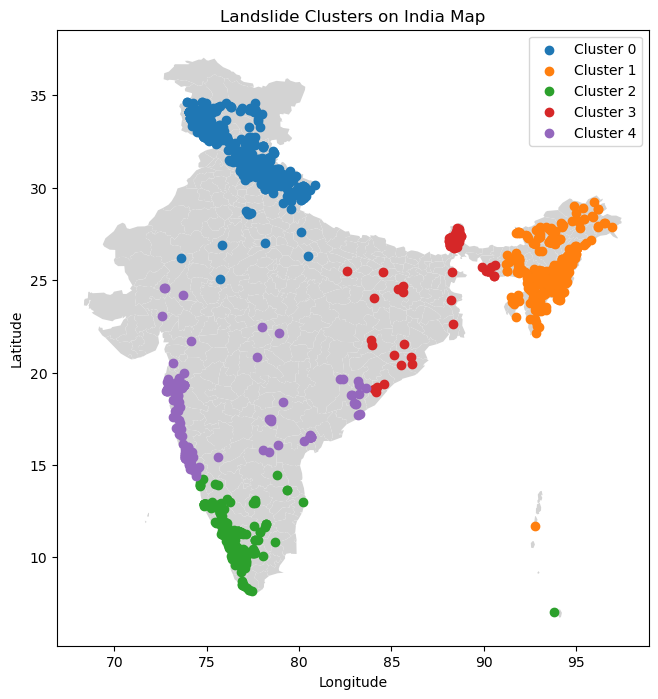

C:\Users\sarah\AppData\Local\Temp\ipykernel_29828\33610620.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buffers = clustered_points.geometry.buffer(buffer_distance)  # Create buffer zones


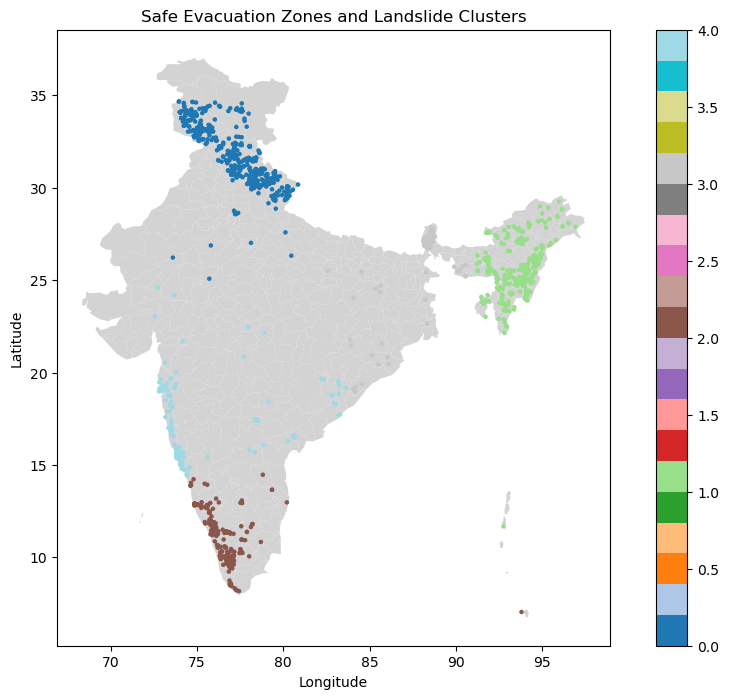

In [9]:
# Main function
def main():
    india_shapefile_path = "C:\\Users\\sarah\\Downloads\\gis mapping\\India Shapefile With Kashmir\\India Shape\\india_ds.shp"
 # Update with your India shapefile path
    landslide_data_path = "C:\\Users\\sarah\\Downloads\\gis mapping\\NasaNew_india.csv"  # Update with your landslide data CSV path
    qgis_project_path = "C:\\Users\\sarah\\Downloads\\gis mapping\\NasaNew_map.qgz"  # Update with your QGIS project file path

    # Load data
    india_gdf, landslide_df = load_data(india_shapefile_path, landslide_data_path)
    
    # Prepare landslide GeoDataFrame
    landslide_gdf = prepare_geodataframe(landslide_df)
    
    # Apply K-means clustering
    n_clusters = 5  # You can adjust the number of clusters
    landslide_gdf = apply_kmeans(landslide_gdf, n_clusters)
    
    # Plot clusters on India map
    plot_clusters_on_map(landslide_gdf, india_gdf, n_clusters)
    
    # Identify safe evacuation zones
    buffer_distance = 0.05  # Adjust buffer distance as needed
    safe_zones = identify_safe_zones(landslide_gdf, buffer_distance)
    
    # Plot safe evacuation zones and clusters
    plot_safe_zones(safe_zones, landslide_gdf, india_gdf)
    
    # Add to QGIS project
    add_to_qgis_project(qgis_project_path, landslide_gdf, safe_zones)

# Run the main function
if __name__ == "__main__":
    main()